In [5]:
import scipy.io
import scipy as sp
import autograd.numpy as np
from autograd import grad 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from autograd import grad 
from autograd import hessian
from autograd import jacobian
from autograd.misc.flatten import flatten_func
from autograd import value_and_grad 
from matplotlib import gridspec
%matplotlib inline

In [6]:
def standard_normalize(x):
    x_means = np.mean(x,axis=1)[:,np.newaxis]
    x_sigma = np.std(x,axis=1)[:,np.newaxis]
    for i in range(len(x_sigma)):
        if x_sigma[i] == 0:
            x_sigma[i] = 1
    x_standard = (x - x_means)/x_sigma
    return x_standard
def pca_sphere(x):
    x_std = standard_normalize(x)
    Cov = x_std@x_std.T
    E,V = np.linalg.eigh(Cov)
    x_sphere = V.T@x_std
    return x_sphere
# gradient descent function 
def conj_gradient_descent(g,alpha,beta,norm,steprule,max_its,w0):

    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w0] # weight history container
    cost_history = [g(w0)] # cost function history container
    #dtemp = gradient(w0)
    dtemp = 0;
    
    for k in range(1,max_its):
        # evaluate the gradient
        grad_eval = gradient(w0)

        # take (momentum-accelerated) gradient descent step
        if norm == 'component':
            d = (1-beta)*dtemp + beta*np.sign(grad_eval)*np.sqrt(len(w0))
        elif norm == 'full':
            grad_eval = grad_eval/np.linalg.norm(grad_eval)
            d = (1-beta)*dtemp + beta*grad_eval
        else:
            d = (1-beta)*dtemp + beta*grad_eval
            
        wtemp = w0;   
        w0 = w0 - alpha*d
        
        if steprule == 'backtrack':
            t = 0.8
            #alpha = 1
            h = g(wtemp)+gradient(wtemp).T@(w0-wtemp)+1/(2*alpha)*np.linalg.norm(w0-wtemp)**2
            while g(w0) > h:
                alpha = t*alpha
                w0 = w0 - alpha*d
                h = g(wtemp)+gradient(wtemp).T@(w0-wtemp)+1/(2*alpha)*np.linalg.norm(w0-wtemp)**2
                wtemp = w0
            w0 = w0 - alpha*d
        elif steprule == 'diminishing':
            alpha = 1/k
        else:
            alpha = alpha
                
        
        # record weight and cost
        weight_history.append(w0)
        cost_history.append(g(w0))
        dtemp = d
    return weight_history,cost_history

In [7]:
def kfoldpartition(k,xp,yp):
    P = len(xp);
    m = np.floor(P/k)
    nT = (k-1)*m; nS = int(P - nT);
    ind = np.random.permutation(P)
    indK = np.split(ind,k)
    XP = []; YP = []
    for i in range(k):
        XP.append(xp[indK[i],:])
        YP.append(yp[indK[i]])
    return XP,YP

def polymat(x,deg):
    m = np.shape(x); N = m[0]; C = m[1];
    if C == 1:
        if deg == 0:
            f = np.ones((N,1))
        elif deg == 1:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis]) ,axis=1)
        else:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,0][:,np.newaxis]**2) ,axis=1)
    if C == 2:
        if deg == 0:
            f = np.ones((N,1))
        elif deg == 1:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,1][:,np.newaxis]) ,axis=1)
        elif deg == 2:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,0][:,np.newaxis]**2,x[:,1][:,np.newaxis]**2) ,axis=1)
        else:
            f = np.concatenate( (np.ones((N,1)), x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,0][:,np.newaxis]**2,x[:,1][:,np.newaxis]**2,x[:,0][:,np.newaxis]*x[:,1][:,np.newaxis]) ,axis=1)
    elif C == 3:
        if deg == 0:
            f = np.ones((N,1))
        elif deg == 1:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,2][:,np.newaxis]) ,axis=1)
        elif deg == 2:
            f = np.concatenate( (np.ones((N,1)),x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,2][:,np.newaxis],x[:,0][:,np.newaxis]**2,x[:,1][:,np.newaxis]**2,x[:,2][:,np.newaxis]**2) ,axis=1)
        else:
            f = np.concatenate( (np.ones((N,1)), x[:,0][:,np.newaxis],x[:,1][:,np.newaxis],x[:,2][:,np.newaxis],x[:,0][:,np.newaxis]**2,x[:,1][:,np.newaxis]**2,x[:,2][:,np.newaxis]**2,x[:,0][:,np.newaxis]*x[:,1][:,np.newaxis],x[:,0][:,np.newaxis]*x[:,2][:,np.newaxis],x[:,1][:,np.newaxis]*x[:,2][:,np.newaxis]) ,axis=1)
    return f

def distanceMatrix(u,v):
    from scipy.spatial import distance_matrix 
    D1 = distance_matrix(u,v)
    return D1

def explKern(u,v,w,kern):
    K = np.zeros(shape=(len(u),len(v)))
    for i in range(len(u)):
        for j in range(len(v)):
            K[i,j] = kern(w,u[i,:],v[j,:])
    return K

def gpr_kernel(theta,xT,xS,kernel):
    DTT = distanceMatrix(xT,xT);
    DTS = distanceMatrix(xT,xS);
    DSS = distanceMatrix(xS,xS);
    if kernel == 'matern':
        # Issue: Kv(v,x) has singularity at x = 0. Must stabilitize DTT/DTS/DSS with 1e-9 on 0 entries. 
        kern = lambda w,x: w[0]*2**(1-w[1])/sp.special.gamma(w[1])*sp.special.kn(w[1],np.sqrt(2)*w[1]*np.abs(x))*(np.sqrt(2)*w[1]*np.abs(x))**w[1]
        K = kern(theta,DTT); Ks = kern(theta,DTS); Kss = kern(theta,DSS);
    elif kernel == 'gaussian':
        kern = lambda w,x: np.exp(-x**2/(2*w[0]))
        K = kern(theta,DTT); Ks = kern(theta,DTS); Kss = kern(theta,DSS);
    elif kernel == 'polynomial':
        kern = lambda w,x,y: (1 + np.dot(x.T,y))**w[0]-1
        K = explKern(xT,xT,theta,kern); Ks = explKern(xT,xS,theta,kern); Kss = explKern(xS,xS,theta,kern);
    else: 
        kern = lambda w,x: np.exp(-np.abs(x)/w[0])
        K = kern(theta,DTT); Ks = kern(theta,DTS); Kss = kern(theta,DSS);
    return K, Ks, Kss

def gpr_kernel_v2(theta,xT,xS,kernel):
    DTT = distanceMatrix(xT,xT);
    DTS = distanceMatrix(xT,xS);
    DSS = distanceMatrix(xS,xS);
    K = np.exp(-DTT**2/(2*theta**2)); Ks = np.exp(-DTS**2/(2*theta**2)); Kss = np.exp(-DTT**2/(2*theta**2));
    return K,Ks,Kss

def calcMuSigma(K,Ks,Kss,yT,poly):
    nP = 1
    nS = len(Kss)
    nT = len(yT)
    sigma_noise = 1e-9;
    mu =  np.dot(Ks.T, np.linalg.solve(K, yT))
    cov = Kss - np.dot(Ks.T, np.linalg.solve(K, Ks))
    stddev = np.sqrt(np.abs(np.diag(cov)))
    L  = np.linalg.cholesky(cov + sigma_noise*np.eye(nS))
    yS = mu.reshape(-1,1)  + np.dot(L, np.random.normal(size=(nS, nP)))
    return yS, mu, cov, stddev
   
def gpr(xT,yT,xS,sigma):
    K,Ks,Kss = gpr_kernel(sigma,xT,xS)
    yS,mu,cov,stddev = calcMuSigma(K,Ks,Kss,yT)
    return yS,mu,cov,stddev
   
def gpr_poly(xT,yT,xS,theta,kernel,deg):
    FT = polymat(xT,deg); FS = polymat(xS,deg);
    K,Ks,Kss = gpr_kernel_v2(theta,xT,xS,kernel); 
    nS = len(xS); nT = len(xT);
    beta = np.linalg.solve(np.dot(FT.T,np.linalg.solve(K,FT)), np.dot(FT.T,np.linalg.solve(K,yT)) )
    cov = 1/nT*np.dot((yT-np.dot(FT,beta)).T,np.linalg.solve(K,yT-np.dot(FT,beta)))
    return beta, cov, K, Ks, Kss, FT, FS

def y_kriging(x,beta,K,FT,xT,yT,theta,deg,kernel):
    d = distanceMatrix(xT,x)
    #r = theta[0]*np.exp(-d**2/(2*theta[1]))
    if kernel == 'matern':
        # Issue: Kv(v,x) has singularity at x = 0. Must stabilitize DTT/DTS/DSS with 1e-9 on 0 entries. 
        kern = lambda w,x: w[0]*2**(1-w[1])/sp.special.gamma(w[1])*sp.special.kn(w[1],np.sqrt(2)*w[1]*np.abs(x))*(np.sqrt(2)*w[1]*np.abs(x))**w[1]
        r = kern(theta,d)
    elif kernel == 'gaussian':
        kern = lambda w,x: np.exp(-x**2/(2*w[0]))
        r = kern(theta,d)
    elif kernel == 'polynomial':
        kern = lambda w,x,y: (1 + np.dot(x.T,y))**w[0]-1
        r = explKern(xT,x,theta,kern)
    else: 
        kern = lambda w,x: np.exp(-np.abs(x)/w[0])
        r = kern(theta,d)
    f = polymat(x,deg)
    
    mu = np.dot(f,beta) + np.dot(r.T,np.linalg.solve(K,yT-np.dot(FT,beta)))
    mse = cov**2*(1 - np.dot(r.T,np.linalg.solve(K,r)))
    
    return mu,mse

def y_kriging_v2(x,beta,cov,K,FT,xT,yT,theta,deg,kernel):
    d = distanceMatrix(xT,x)
    r = np.exp(-d**2/(2*theta**2))
    f = polymat(x,deg)
    mu = np.dot(f,beta) + np.dot(r.T,np.linalg.solve(K,yT-np.dot(FT,beta)))
    mse = cov**2*(1 - np.dot(r.T,np.linalg.solve(K,r)))
    return mu,mse

def mse_kriging(x,cov,K,FT,xT,yT,theta,deg,kernel):
    d = distanceMatrix(xT,x)
    #r = theta[0]*np.exp(-d**2/(2*theta[1]))
    if kernel == 'matern':
        # Issue: Kv(v,x) has singularity at x = 0. Must stabilitize DTT/DTS/DSS with 1e-9 on 0 entries. 
        kern = lambda w,x: w[0]*2**(1-w[1])/sp.special.gamma(w[1])*sp.special.kn(w[1],np.sqrt(2)*w[1]*np.abs(x))*(np.sqrt(2)*w[1]*np.abs(x))**w[1]
        r = kern(theta,d)
    elif kernel == 'gaussian':
        kern = lambda w,x: np.exp(-x**2/(2*w[0]))
        r = kern(theta,d)
    elif kernel == 'polynomial':
        kern = lambda w,x,y: (1 + np.dot(x.T,y))**w[0]-1
        r = explKern(xT,x,theta,kern);
    else: 
        kern = lambda w,x: np.exp(-np.abs(x)/w[0])
        r = kern(theta,d)
    f = polymat(x,deg)
    return cov**2*(1 - np.dot(r.T,np.linalg.solve(K,r)))

def gpr_mle(theta,xT,yT,xS,kernel,deg,epsilon):
    #epsilon = 10**-9 # regularization parameter to stabilize np.cholesky(K + eta*np,eye(N))
    N = len(yT)
    beta,cov,K,Ks,Kss,FT,FS = gpr_poly(xT,yT,xS,theta,kernel,deg)
    #mle = -N/2*np.log(2*np.pi*cov**2) - 1/2*np.log(np.linalg.det(K+0*np.eye(N))) - 1/(2*cov**2)*np.dot( (yT-np.dot(FT,beta)).T,yT-np.dot(FT,beta))
    mle =  - 1/2*np.log(np.linalg.det(np.linalg.cholesky(K+epsilon*np.eye(N)))) - 1/(2*cov**2)*np.dot( (yT-np.dot(FT,beta)).T,yT-np.dot(FT,beta))  -N/2*np.log(2*np.pi*cov**2) 
    #mle = -1/2*np.log(np.linalg.det(K + 1e-9*np.eye(N))) - np.dot(np.dot( (yT-np.dot(FT,beta)).T,K),yT-np.dot(FT,beta))
    return -mle
    #return cov
    
def acquisition(mu,yT,sigma):
    from scipy.stats import norm
    z = (mu - np.max(yT))/sigma
    return norm.cdf(z,loc=0,scale=1)

def plot_gpr(s,s2,xT,yT,Y,ySS,MSE,dim):
    from scipy.stats import norm
    
    z = (ySS - np.max(yT))/np.sqrt(MSE)
    phi = norm.cdf(z,loc=0,scale=1)
    
    if dim == 2:
        xplot1,yplot1 = np.meshgrid(s,s)
        xplot2,yplot2 = np.meshgrid(s2,s2)

        fig = plt.figure(figsize = (30,18))
        plt.rcParams.update({'font.size': 22})
        gs = gridspec.GridSpec(2,2) 

        ax1 = plt.subplot(gs[0],projection='3d');
        ax2 = plt.subplot(gs[1],projection='3d');
        ax3 = plt.subplot(gs[2],projection='3d');
        ax4 = plt.subplot(gs[3],projection='3d');

        im1 = ax1.plot_wireframe(xplot2,yplot2,ySS,alpha = 0.9,color = [0.5, 0.3, 0.8])
        ax1.plot_wireframe(xplot2,yplot2,ySS+2*np.sqrt(MSE),alpha = 0.1,color = 'r')
        ax1.plot_wireframe(xplot2,yplot2,ySS-2*np.sqrt(MSE),alpha = 0.1,color = 'r')
        ax1.set_xlabel('x',labelpad=20)
        ax1.set_ylabel('y',labelpad=20)
        ax1.set_zlabel('z',labelpad=20)
        ax1.set_title('Kriging Interpolation',fontsize = 20,y=1.08)
        ax1.scatter(xT[:,0],xT[:,1],yT,s=60,color=[1,0,0])
        #ax1.set_xlim([-3,3])
        #ax1.set_ylim([-3,3])
        #ax1.view_init(1,80)

        im2 = ax2.plot_wireframe(xplot1,yplot1,Y,alpha = 0.9,color = [0.5, 0.3, 0.8])
        ax2.set_xlabel('x',labelpad=20)
        ax2.set_ylabel('y',labelpad=20)
        ax2.set_zlabel('z',labelpad=20)
        ax2.set_title('Original Data',fontsize = 20,y=1.08);
        ax2.scatter(xp[:,0],xp[:,1],yp[:,0])
        #ax4.view_init(10,4)

        im3 = ax3.plot_wireframe(xplot2,yplot2,MSE,alpha = 0.9,color = [0.5, 0.3, 0.8])
        ax3.set_xlabel('x',labelpad=20)
        ax3.set_ylabel('y',labelpad=20)
        ax3.scatter(xT[:,0],xT[:,1],0,s=60,color=[1,0,0])
        ax3.set_title('Mean-Square Error',fontsize = 20,y=1.03)
        
        im4 = ax4.plot_wireframe(xplot2,yplot2,phi,alpha = 0.9,color = [0, 0.7, 0])
        ax4.set_xlabel('x',labelpad=20)
        ax4.set_ylabel('y',labelpad=20)
        ax4.scatter(xT[:,0],xT[:,1],0,s=60,color=[1,0,0])
        ax4.set_title('Acquisition Function',fontsize = 20,y=1.03)
        
    else: # 1D plot
        mu_min = np.min(ySS); Y_min = np.min(Y); mu_max = np.max(ySS); Y_max = np.max(Y);
        plt.rcParams.update({'font.size': 35})
        fig = plt.figure(figsize = (32,20))
        gs = gridspec.GridSpec(2,1); 
        ax1 = plt.subplot(gs[0]); ax2 = plt.subplot(gs[1]);
        ax1.plot(xT, yT, 'o', ms=22, mfc='#348ABD', mec='none', label='Training Set' )
        ax1.plot(s, Y, '#dddddd', lw=3, label='Data',color=[0,0,0])
        ax1.plot(s2, ySS, '#A60628', lw=3, label='Mean')
        # fill 95% confidence interval (2*sd about the mean)
        ax1.fill_between(s2, ySS-2*np.sqrt(np.abs(MSE)), ySS+2*np.sqrt(np.abs(MSE)), color="#348ABD", alpha=0.25, label='2 sigma')
        ax1.grid(True)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.legend(loc=1)
        #plt.ylim([np.min([mu_min,Y_min])-1, np.max([mu_max,Y_max])+1 ])
        #fig.savefig('GPR_1D_Example.svg',format='svg')
        ax2.fill_between(s2, np.zeros(len(phi)), phi, color=[0,0.7,0], alpha=0.25, label='PI')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.legend(loc=1)
        ax2.grid(True)
        plt.show()

In [8]:
### 1D Dataset Training ###

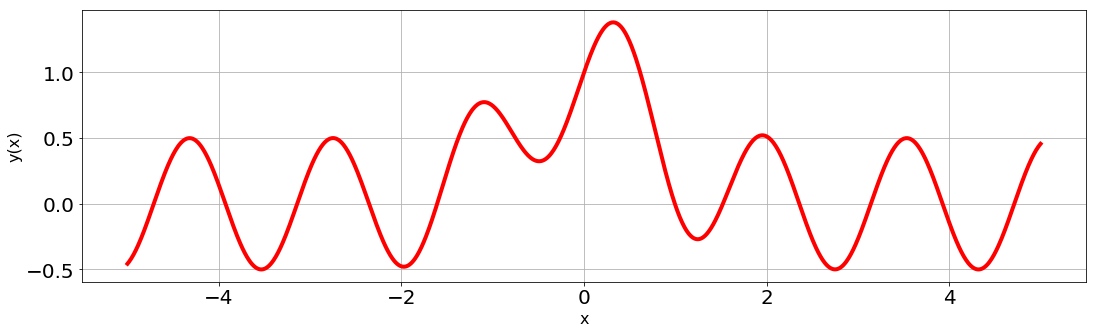

In [13]:
N = 1200
s = np.linspace(-5,5,N)

def hermite(n,x):
    import math
    from autograd import numpy as np
    A = 0
    for m in range(np.int_(np.floor(n/2)+1)):
        A = A + (-1)**m/(math.factorial(m)*math.factorial(n-2*m)) * (2*x)**(n-2*m)   
    return A*math.factorial(n)

#Y = 2*s*np.tanh(s**2)*np.exp(-s)
#Y  = hermite(6,s)*np.exp(-s**2)
#Y = 1/2*(1 + np.tanh(s/0.1))
Y = np.exp(-s**2) + np.cos(2*s)*np.sin(2*s)
xp = s[:,np.newaxis]; yp = Y;

fig = plt.figure(figsize = (18,5))
plt.rcParams.update({'font.size': 20})
gs = gridspec.GridSpec(1,1) 
ax1 = plt.subplot(gs[0]); 
ax1.plot(s,Y,linewidth=4,color=[1,0,0])
ax1.set_xlabel('x',Fontsize=16)
ax1.set_ylabel('y(x)',Fontsize=16)
ax1.grid(True)

In [22]:
# Training Set 1: Simple Subsampling (Train on 1% of the data)
D = 1
P = len(yp)
kfold = 0
regular = 0

inds = np.random.permutation(P)

if regular == 1:
    nsamp = 100
    xT = np.zeros(shape=(int(P/nsamp),D));    yT = np.zeros(shape=(int(P/nsamp),1));
    xS = np.zeros(shape=(int(P-P/nsamp),D));  yS = np.zeros(shape=(int(P-P/nsamp),1)); 
    cS = 0
    cT = 0
    for i in range(P):
        I = inds[i]
        #I = i
        if i%nsamp == 0:
            xT[cT] = xp[I]
            yT[cT] = yp[I]
            cT += 1
        else:
            xS[cS] = xp[I]
            yS[cS] = yp[I]
            cS += 1
else:       
    nT = 3
    xT = xp[inds[:nT]]
    yT = yp[inds[:nT]]
        
if kfold == 1:
    k = 5
    XP,YP = kfoldpartition(k,xp,yp)
    for i in range(k):
        xS = XP[i];
        yS = YP[i];
        xT = np.vstack((XP[(i+1)%k],XP[(i+2)%k],XP[(i+3)%k],XP[(i+4)%k]))
        yT = np.vstack((YP[(i+1)%k][:,np.newaxis],YP[(i+2)%k][:,np.newaxis],YP[(i+3)%k][:,np.newaxis],YP[(i+4)%k][:,np.newaxis]))
        yT = np.squeeze(yT)


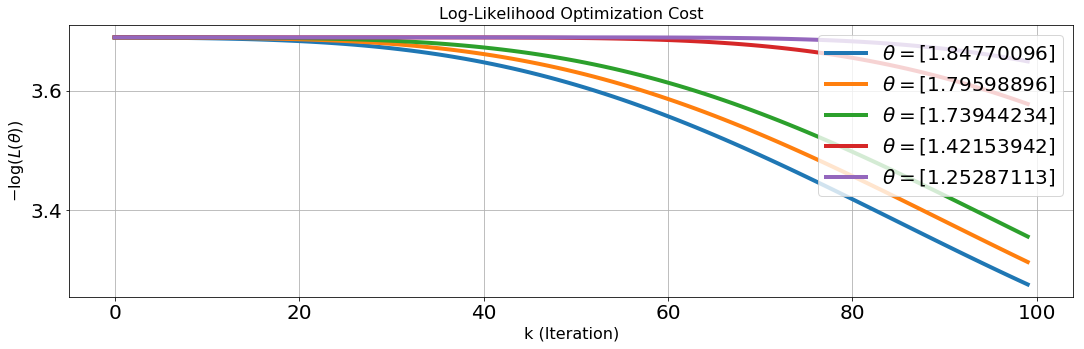

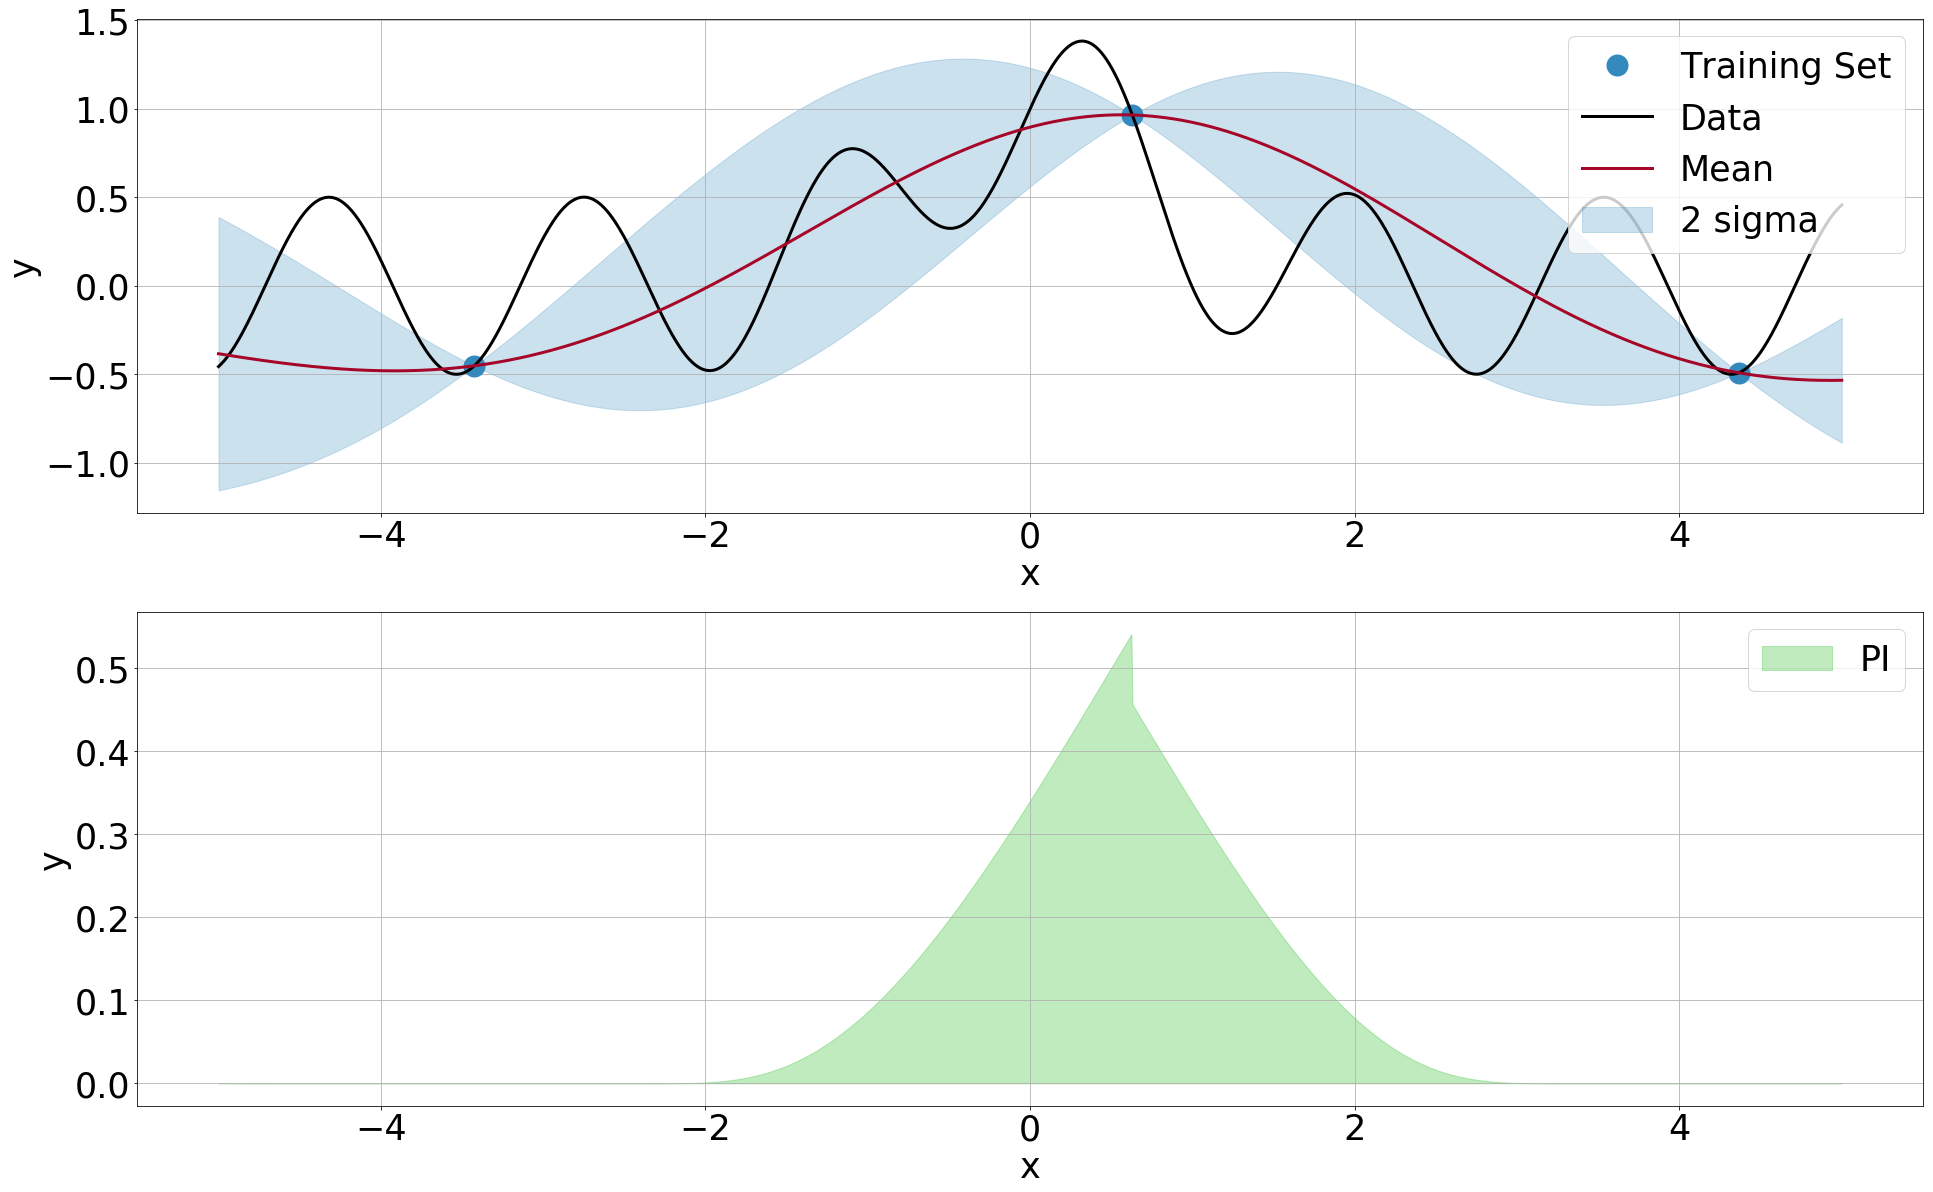

In [23]:
# Hyperparameter Optimization
kernel = 'gaussian'
deg = 0
epsilon = 10**-9
fun = lambda w: gpr_mle(w,xT,yT,xS,kernel,deg,epsilon)

nruns = 5

cost_hist = []
cost_min = np.zeros(nruns)
weight_hist = []

for i in range(nruns):
    w0 = np.random.rand(1)
    alpha = 0.01
    beta = 0.5
    steprule = 'standard'
    normalization = 'component'
    max_its = 100
    w1,g1 = conj_gradient_descent(fun,alpha,beta,normalization,steprule,max_its,w0)
    cost_hist.append(np.squeeze(g1))
    cost_min[i] = g1[-1]
    weight_hist.append(w1[-1])
    
wopt = weight_hist[np.argmin(cost_min)]

fig = plt.figure(figsize = (18,5))
plt.rcParams.update({'font.size': 20})
gs = gridspec.GridSpec(1,1) 
ax1 = plt.subplot(gs[0]); 
for i in range(nruns):
    ax1.plot(np.arange(0,max_its),cost_hist[i],label=r'$\theta = $' + str(weight_hist[i]),linewidth=4)
ax1.set_title('Log-Likelihood Optimization Cost',Fontsize=16)
ax1.set_ylabel(r'$-\log(L(\theta))$',Fontsize=16)
ax1.set_xlabel('k (Iteration)',Fontsize=16)
ax1.grid(True)
ax1.legend(loc=1)


# Construct GPR Model
theta = wopt
beta,cov,K,Ks,Kss,FT,FS = gpr_poly(xT,yT,xS,theta,kernel,deg)
ypred = lambda a: y_kriging_v2(a,beta,cov,K,FT,xT,yT,theta,deg,kernel)

M = 1500
s2 = np.linspace(-5,5,M)
ySS = np.zeros(M)
MSE = np.zeros(M)

for i in range(len(s2)):
    a = np.array([s2[i]])[np.newaxis,:]
    u,v = ypred(a)
    ySS[i] = u; MSE[i] = v;
plot_gpr(s,s2,xT,yT,Y,ySS,MSE,D)


In [1336]:
### 2D Dataset Training ###

In [67]:
# Generate "experimental" data (2D)
N = 20
P = N**2
D = 2
s = np.linspace(-np.pi,np.pi,N)
Y = np.zeros(shape=(N,N))
xp = np.zeros(shape=(N**2,D)); yp = np.zeros((N**2,1))
count = 0
for i in range(len(s)):
    for j in range(len(s)):
        a = np.array([s[i],s[j]])
        Y[j,i] = 2.5*np.exp(-(s[i]**2+s[j]**2)) + np.sin(2*s[i]) + np.cos(s[j])
        #Y[j,i] = 2*np.sin(s[i])*np.cos(2*s[j])*np.exp(-(s[j]+s[i])**2/100)
        xp[count,:] = a
        yp[count,:] = Y[j,i]
        count += 1

In [68]:
nsamp = 20
xT = np.zeros(shape=(int(P/nsamp),D));    yT = np.zeros(shape=(int(P/nsamp),1));
xS = np.zeros(shape=(int(P-P/nsamp),D));  yS = np.zeros(shape=(int(P-P/nsamp),1));
  
inds = np.random.permutation(P)
cS = 0
cT = 0
for i in range(P):
    I = inds[i]
    if i%nsamp == 0:
        xT[cT,:] = xp[I,:]
        yT[cT] = yp[I]
        cT += 1
    else:
        xS[cS,:] = xp[I,:]
        yS[cS] = yp[I]
        cS += 1

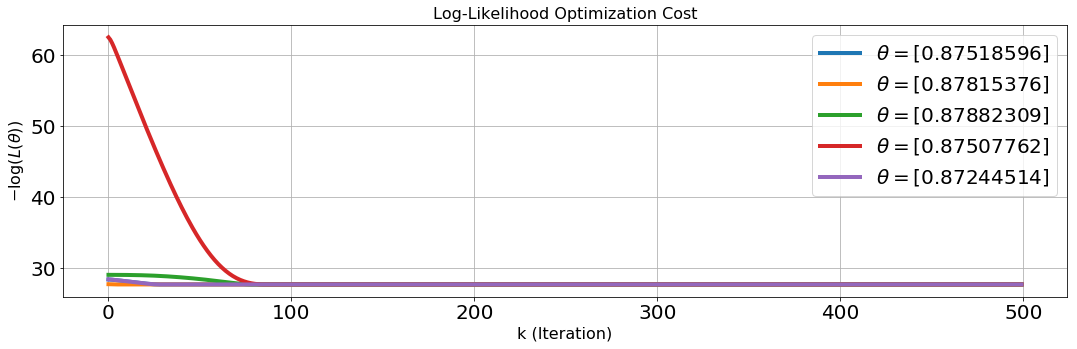

In [69]:
deg = 1
epsilon = 10**-8
fun = lambda w: gpr_mle(w,xT,yT,xS,kernel,deg,epsilon)

nruns = 5

cost_hist = []
cost_min = np.zeros(nruns)
weight_hist = []

for i in range(nruns):
    w0 = 2*np.random.rand(1)
    alpha = 0.01
    beta = 0.5
    steprule = 'standard'
    normalization = 'component'
    max_its = 500
    w1,g1 = conj_gradient_descent(fun,alpha,beta,normalization,steprule,max_its,w0)
    cost_hist.append(np.squeeze(g1))
    cost_min[i] = g1[-1]
    weight_hist.append(w1[-1])
    
wopt = weight_hist[np.argmin(cost_min)]

fig = plt.figure(figsize = (18,5))
plt.rcParams.update({'font.size': 20})
gs = gridspec.GridSpec(1,1) 
ax1 = plt.subplot(gs[0]); 
for i in range(nruns):
    ax1.plot(np.arange(0,max_its),cost_hist[i],label=r'$\theta = $' + str(weight_hist[i]),linewidth=4)
ax1.set_title('Log-Likelihood Optimization Cost',Fontsize=16)
ax1.set_ylabel(r'$-\log(L(\theta))$',Fontsize=16)
ax1.set_xlabel('k (Iteration)',Fontsize=16)
ax1.grid(True)
ax1.legend(loc=1)

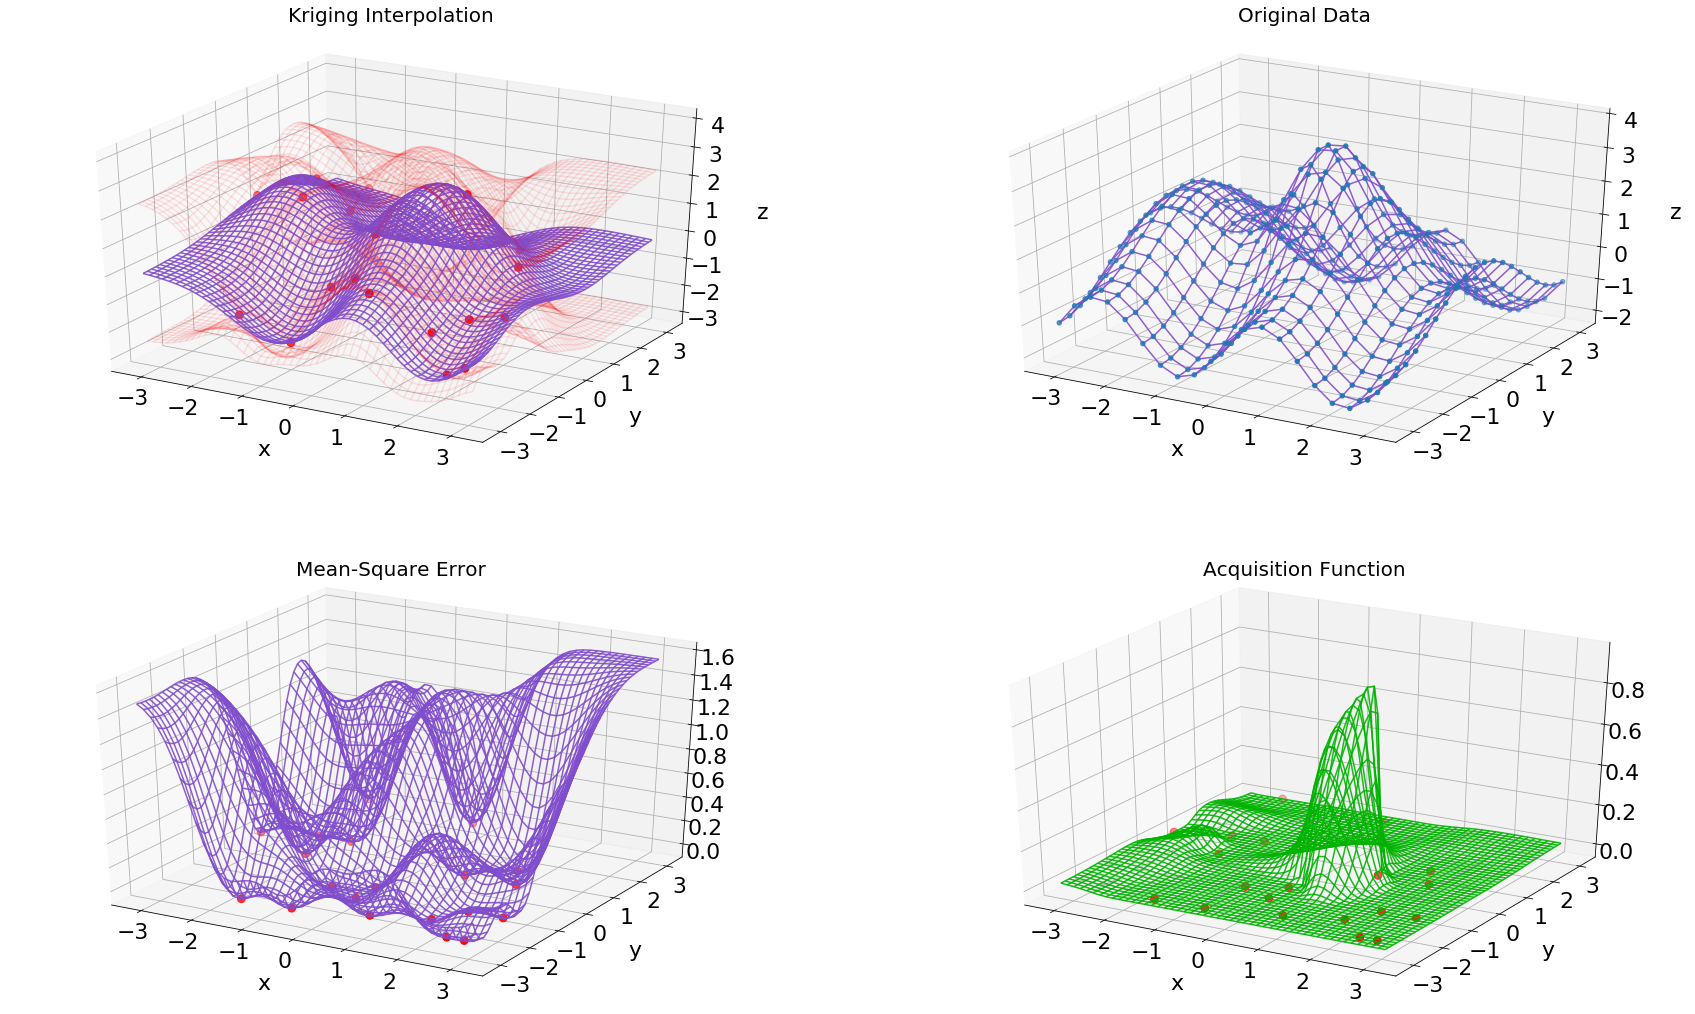

In [70]:
theta = wopt
kernel = 'gaussian'

beta,cov,K,Ks,Kss,FT,FS = gpr_poly(xT,yT,xS,theta,kernel,deg)

ypred = lambda a: y_kriging_v2(a,beta,K,FT,xT,yT,theta,deg,kernel)
#msepred = lambda a: mse_kriging(a,cov,K,FT,xT,yT,theta,deg,kernel)

M = 50
s2 = np.linspace(-np.pi,np.pi,M)
ySS = np.zeros(shape=(M,M))
MSE = np.zeros(shape=(M,M))
count = 0
for i in range(len(s2)):
    for j in range(len(s2)):
        a = np.array([s2[i],s2[j]])[np.newaxis,:]
        u,v = ypred(a)
        ySS[j,i] = u
        MSE[j,i] = v
plot_gpr(s,s2,xT,yT,Y,ySS,MSE,D)

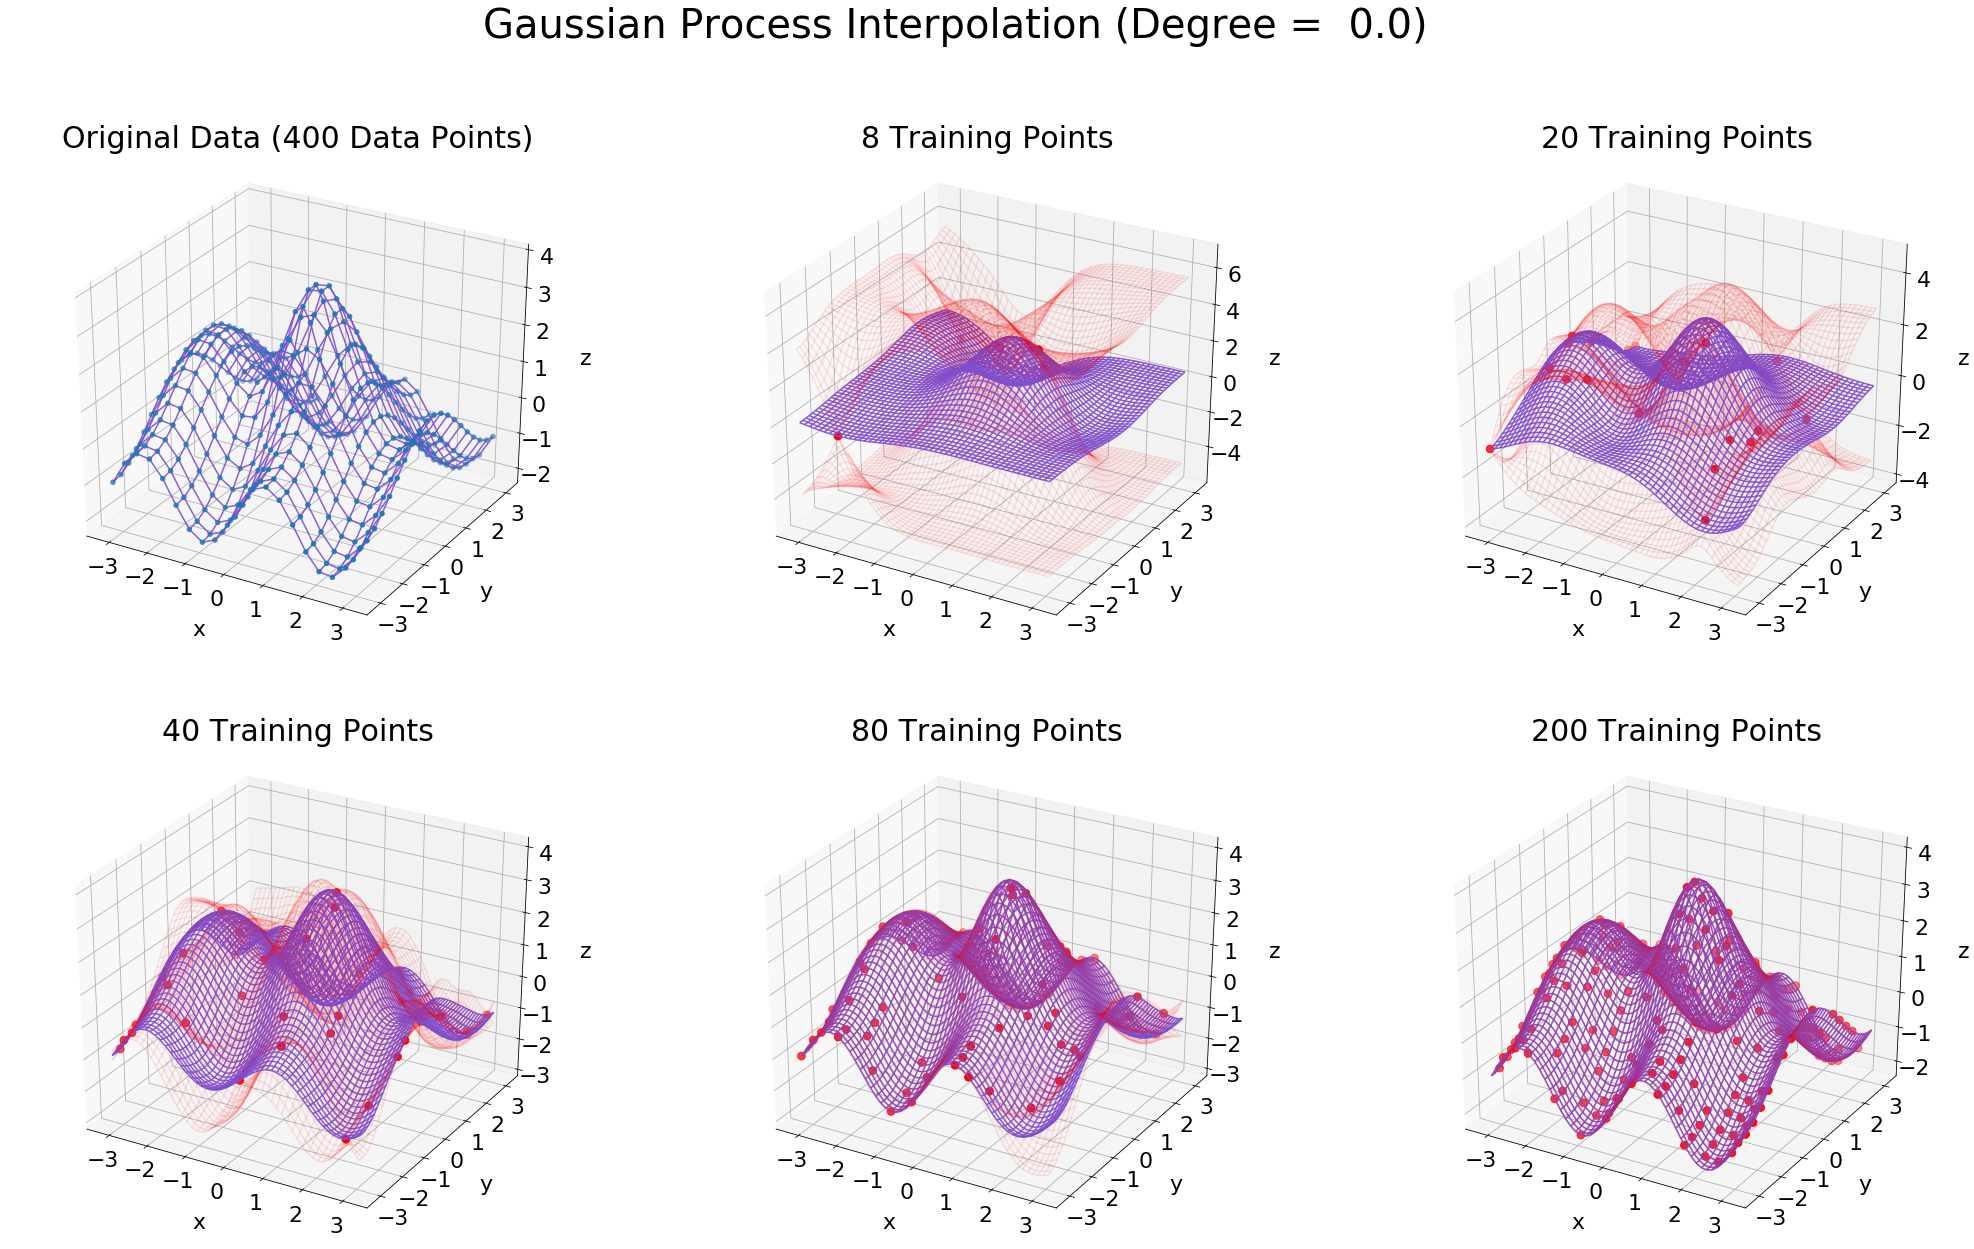

In [1518]:
# 2D GPR Figure
P = len(yp)
D = 2

samplingfreq = np.array([50,20,10,5,2])
XT = []; YT = []; YSS = []; MSEE = [];

for A1 in range(len(samplingfreq)):
    nsamp = samplingfreq[A1]
    xT = np.zeros(shape=(int(P/nsamp),D));    yT = np.zeros(shape=(int(P/nsamp),1));
    xS = np.zeros(shape=(int(P-P/nsamp),D));  yS = np.zeros(shape=(int(P-P/nsamp),1));
  
    inds = np.random.permutation(P)
    cS = 0
    cT = 0
    for i in range(P):
        I = inds[i]
        if i%nsamp == 0:
            xT[cT,:] = xp[I,:]
            yT[cT] = yp[I]
            cT += 1
        else:
            xS[cS,:] = xp[I,:]
            yS[cS] = yp[I]
            cS += 1

    deg = 0
    theta = np.array([1.05])
    kernel = 'gaussian'

    beta,cov,K,Ks,Kss,FT,FS = gpr_poly(xT,yT,xS,theta,kernel,deg)

    ypred = lambda a: y_kriging_v2(a,beta,K,FT,xT,yT,theta,deg,kernel)

    M = 50
    s2 = np.linspace(-np.pi,np.pi,M)
    ySS = np.zeros(shape=(M,M))
    MSE = np.zeros(shape=(M,M))
    count = 0
    for i in range(len(s2)):
        for j in range(len(s2)):
            a = np.array([s2[i],s2[j]])[np.newaxis,:]
            u,v = ypred(a)
            ySS[j,i] = u
            MSE[j,i] = v
            
    XT.append(xT); YT.append(yT); YSS.append(ySS); MSEE.append(MSE);
        
#plot_gpr(s,s2,xT1,yT1,Y,ySS1,MSE1,D)

xplot1,yplot1 = np.meshgrid(s,s)
xplot2,yplot2 = np.meshgrid(s2,s2)

fig = plt.figure(figsize = (35,20))
plt.rcParams.update({'font.size': 22})
gs = gridspec.GridSpec(2,3)

for i in range(len(YSS)+1):
    ax1 = plt.subplot(gs[i],projection='3d');
    if i != 0:
        ySS = YSS[i-1]; xT = XT[i-1]; yT = YT[i-1]; MSE = MSEE[i-1];
        im1 = ax1.plot_wireframe(xplot2,yplot2,ySS,alpha = 0.9,color = [0.5, 0.3, 0.8])
        ax1.plot_wireframe(xplot2,yplot2,ySS+2*np.sqrt(MSE),alpha = 0.1,color = 'r')
        ax1.plot_wireframe(xplot2,yplot2,ySS-2*np.sqrt(MSE),alpha = 0.1,color = 'r')
        ax1.set_xlabel('x',labelpad=20)
        ax1.set_ylabel('y',labelpad=20)
        ax1.set_zlabel('z',labelpad=20)
        ax1.set_title('%d Training Points' %(P/samplingfreq[i-1]),fontsize = 30,y=1.08)
        ax1.scatter(xT[:,0],xT[:,1],yT,s=60,color=[1,0,0])
    else:
        xplot1,yplot1 = np.meshgrid(s,s)
        im1 = ax1.plot_wireframe(xplot1,yplot1,Y,alpha = 0.9,color = [0.5, 0.3, 0.8])
        ax1.set_xlabel('x',labelpad=20)
        ax1.set_ylabel('y',labelpad=20)
        ax1.set_zlabel('z',labelpad=20)
        ax1.set_title('Original Data (%d Data Points)' %(P),fontsize = 30,y=1.08);
        ax1.scatter(xp[:,0],xp[:,1],yp[:,0])
    plt.suptitle('Gaussian Process Interpolation (Degree = %4.1f)' %(deg),fontsize=40)

In [568]:
### 3D Dataset Training ###

In [591]:
# Generate "experimental" data (3D)
N = 20
D = 3
s = np.linspace(-1,1,N)
Y = np.zeros(shape=(N,N,N))
xp = np.zeros(shape=(N**D,D)); yp = np.zeros((N**D,1))
count = 0
for i in range(len(s)):
    for j in range(len(s)):
        for k in range(len(s)):
            a = np.array([s[i],s[j],s[k]])
            #Y[i,j,k] = 2.5*np.exp(-(s[i]**2+s[j]**2+s[k]**2)/10) + np.sin(2*s[i]) + np.cos(s[j]) + 6*np.cos(s[k])
            Y[i,j,k] = np.exp(-(s[i]**2+s[j]**2+s[k]**2)/10) + np.sin(2*s[i]) + np.cos(s[j]) + 6*np.cos(s[k])
            xp[count,:] = a
            yp[count,:] = Y[i,j,k]
            count += 1

In [592]:
# Training Set 1: Simple Subsampling
P = len(yp)
nsamp = 10
xT = np.zeros(shape=(int(P/nsamp),D));    yT = np.zeros(shape=(int(P/nsamp),1));
xS = np.zeros(shape=(int(P-P/nsamp),D));  yS = np.zeros(shape=(int(P-P/nsamp),1));
  
inds = np.random.permutation(P)
cS = 0
cT = 0
for i in range(P):
    I = inds[i]
    if i%nsamp == 0:
        xT[cT,:] = xp[I,:]
        yT[cT] = yp[I]
        cT += 1
    else:
        xS[cS,:] = xp[I,:]
        yS[cS] = yp[I]
        cS += 1
        
deg = 0
sigma = 1
kernel = 'gaussian'

beta,cov,K,Ks,Kss,FT,FS = gpr_poly(xT,yT,xS,sigma,kernel,deg)
ypred = lambda a: y_kriging(a,beta,K,FT,xT,yT,sigma,deg,kernel)
msepred = lambda a: mse_kriging(a,cov,K,FT,xT,yT,sigma,deg,kernel)

M = 30
s2 = np.linspace(-1,1,M)
ySS = np.zeros(shape=(M,M,M))
MSE = np.zeros(shape=(M,M,M))
count = 0
for i in range(len(s2)):
    for j in range(len(s2)):
        for k in range(len(s2)):
            a = np.array([s2[i],s2[j],s2[k]])[np.newaxis,:]
            ySS[i,j,k] = ypred(a)
            MSE[i,j,k] = msepred(a)

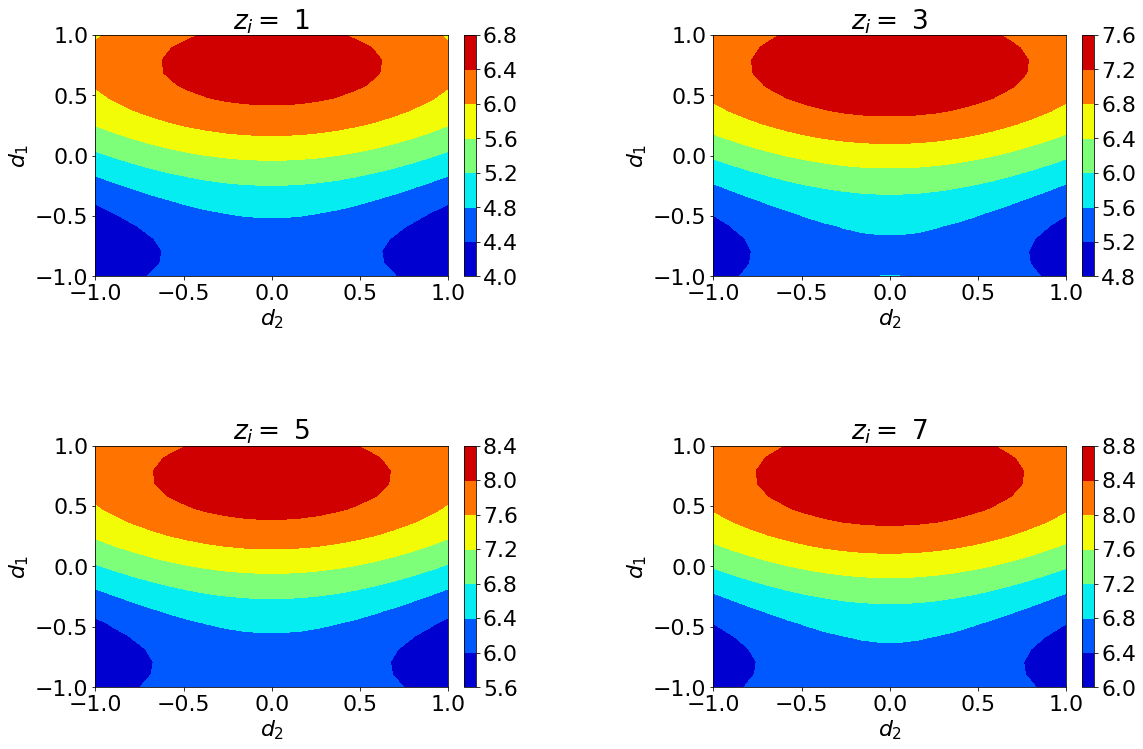

In [593]:
fig = plt.figure(figsize = (18,12))
plt.rcParams.update({'font.size': 22})

gs = gridspec.GridSpec(2,2) 
gs.update(wspace=0.6, hspace=0.7) # set the spacing between axes.

inds = [1,3,5,7]
for i in range(len(inds)):
    ax = plt.subplot(gs[i])
    im = ax.contourf(s,s,np.squeeze(Y[:,:,inds[i]]),cmap='jet')
    plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
    ax.set_xlabel(r'$d_2$')
    ax.set_ylabel(r'$d_1$')
    ax.set_title(r'$z_i =$ %d' %(inds[i]))

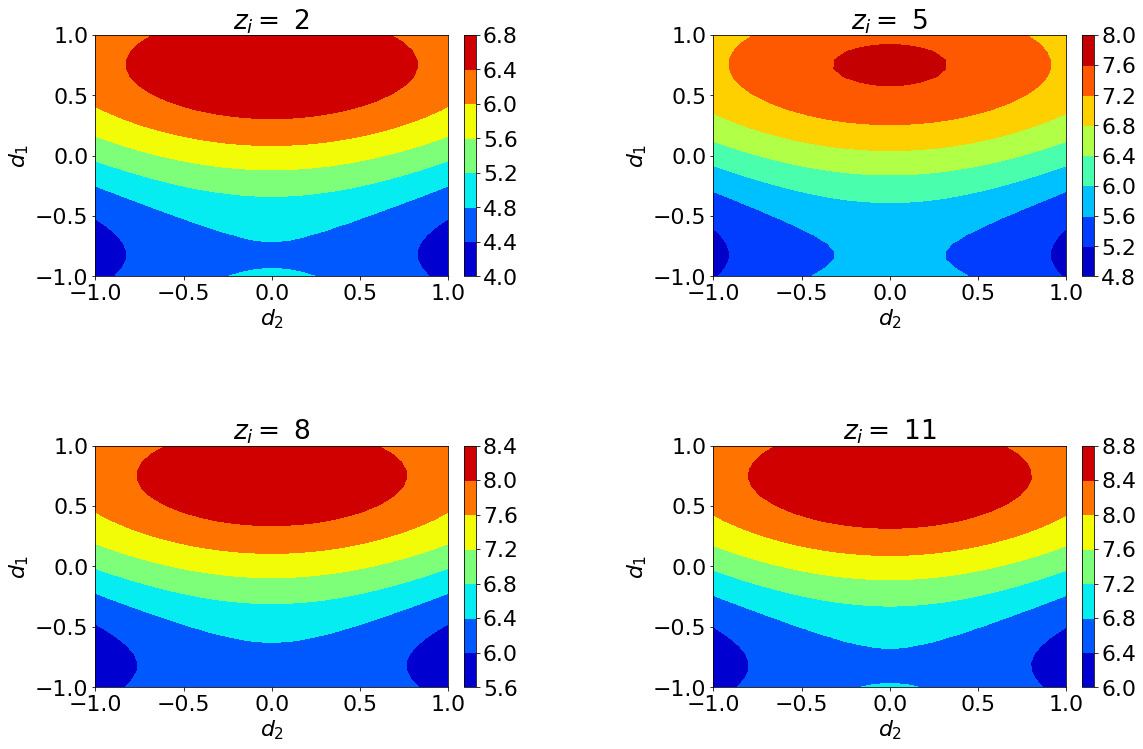

In [608]:
fig = plt.figure(figsize = (18,12))
plt.rcParams.update({'font.size': 22})

gs = gridspec.GridSpec(2,2) 
gs.update(wspace=0.6, hspace=0.7) # set the spacing between axes.

inds2 = np.zeros(len(inds))
for i in range(len(inds)):
    inds2[i] = np.argmin(np.abs(s[inds[i]]-s2))
inds2 = inds2[:,np.newaxis].astype(int)
for i in range(len(inds2)):
    ax = plt.subplot(gs[i])
    im = ax.contourf(s2,s2,np.squeeze(ySS[:,:,inds2[i]]),cmap='jet')
    plt.colorbar(im,ax=ax,fraction=0.046, pad=0.04)
    ax.set_xlabel(r'$d_2$')
    ax.set_ylabel(r'$d_1$')
    ax.set_title(r'$z_i =$ %d' %(inds2[i]))

In [615]:
# Calculate error in fit
IND = np.zeros(len(s))
for i in range(len(s)):
    IND[i] = np.argmin(np.abs(s[i]-s2))
IND = IND[:,np.newaxis].astype(int)

Error = np.sum(Y - ySS[IND,IND,IND])**2

print(Error)

96898.10674083659
